In [9]:
import pandas as pd
df = pd.read_csv("/home/spatialuser/uribe/mapmetadata/jakarta_mini_inf_metadata_20250813-092915.csv")
df

,u,v,k,osmid,inf_oneway,osm_oneway,inf_exp_speed,inf_speed_limit,osm_maxspeed,inf_lanes,osm_lanes,osm_highway,count,min_s,max_s,q1,q2,q3,uv_vu
0,3594842524,1709839502,0,319804349,False,True,37.1300,80,80.0,4,3,motorway,49,28.63,73.30,34.4900,37.1300,39.3800,"(42, 5)"
1,3255159702,3255159705,0,158850426,True,True,31.2588,60,NaN,1,2,residential,3,31.26,53.42,53.4168,31.2588,32.4972,"(0, 1)"
2,2408624358,2408398057,0,157354963,True,False,31.7052,60,NaN,1,2,tertiary,2,31.71,56.24,56.2356,31.7052,NaN,"(0, 0)"
3,10859145193,2408617532,0,1167643183,False,True,26.3400,70,80.0,1,3,motorway,8,22.36,66.46,24.3400,26.3400,36.3700,"(5, 1)"
4,10859145187,10859145193,0,696669870,False,True,23.0000,30,80.0,1,3,motorway,21,4.41,65.99,19.4700,23.0000,24.1400,"(14, 5)"
5,2408617531,2408617533,0,103233804,False,True,27.9900,70,80.0,1,4,motorway,7,19.00,63.45,23.4200,27.9900,40.8700,"(4, 1)"
6,10859145186,2408617531,0,103233804,False,True,18.0500,70,80.0,1,4,motorway,7,10.22,67.63,12.7600,18.0500,36.4600,"(4, 1)"
7,2408702963,2408702964,0,232494779,True,True,67.0000,80,80.0,1,3,motorway,4,63.72,71.69,64.0000,67.0000,70.0000,"(3, 0)"
8,2408624352,11430301508,0,247354201,True,True,16.8900,20,80.0,1,3,motorway,12,14.30,63.63,15.9300,16.8900,18.5900,"(10, 0)"
9,2408702964,11236769944,0,232494779,True,True,NaN,80,80.0,1,3,motorway,1,70.62,70.62,70.6248,NaN,NaN,"(0, 0)"


### Inferred Oneway

#### Accuracy: 71

In [11]:
accuracy = (df['inf_oneway'] == df['osm_oneway']).mean()
accuracy

0.7105263157894737

In [ ]:
def resolve_oneway(group):
    if False in group.values:
        return False
    elif True in group.values:
        return True
    else:
        return False
# Group by 'osmid' and apply logic to 'oneway'
result = df.groupby('osmid')['inf_oneway'].apply(resolve_oneway).reset_index()
result

def resolve_oneway_osm(group):
    if False in group.values:
        return False
    elif True in group.values:
        return True
    else:
        return None

agg_result = df.groupby('osmid').agg({
    'inf_oneway': resolve_oneway,
    'osm_oneway': resolve_oneway_osm
}).reset_index()

agg_result

accuracy = (df['inf_oneway'] == df['osm_oneway']).mean()
print(f"Accuracy: {accuracy:.4f}")

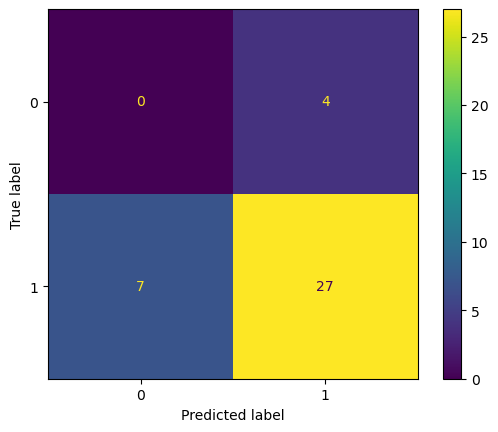

In [16]:
import sklearn.metrics as skl

cm = skl.confusion_matrix(list(df['osm_oneway']), list(df['inf_oneway']))
cm_display = skl.ConfusionMatrixDisplay(cm)
cm_display.plot()

#### False Positives/Negatives

In [ ]:
false_negatives = df[~df['inf_oneway'] & df['osm_oneway']]
false_negatives

,u,v,k,osmid,inf_oneway,osm_oneway,inf_exp_speed,inf_speed_limit,osm_maxspeed,inf_lanes,osm_lanes,osm_highway,count,min_s,max_s,q1,q2,q3,uv_vu
0,3594842524,1709839502,0,319804349,False,True,37.13,80,80.0,4,3,motorway,49,28.63,73.30,34.49,37.13,39.38,"(42, 5)"
3,10859145193,2408617532,0,1167643183,False,True,26.34,70,80.0,1,3,motorway,8,22.36,66.46,24.34,26.34,36.37,"(5, 1)"
4,10859145187,10859145193,0,696669870,False,True,23.00,30,80.0,1,3,motorway,21,4.41,65.99,19.47,23.00,24.14,"(14, 5)"
5,2408617531,2408617533,0,103233804,False,True,27.99,70,80.0,1,4,motorway,7,19.00,63.45,23.42,27.99,40.87,"(4, 1)"
6,10859145186,2408617531,0,103233804,False,True,18.05,70,80.0,1,4,motorway,7,10.22,67.63,12.76,18.05,36.46,"(4, 1)"
13,10857491744,10857491743,0,232494779,False,True,37.84,80,80.0,1,3,motorway,5,15.67,71.89,23.75,37.84,51.92,"(2, 1)"
36,5668743335,6458853200,0,375363329,False,True,40.29,80,NaN,7,2,secondary,56,2.86,72.08,32.15,40.29,48.32,"(19, 36)"


In [25]:
false_positives = df[df['inf_oneway'] & ~df['osm_oneway']]
false_positives

,u,v,k,osmid,inf_oneway,osm_oneway,inf_exp_speed,inf_speed_limit,osm_maxspeed,inf_lanes,osm_lanes,osm_highway,count,min_s,max_s,q1,q2,q3,uv_vu
2,2408624358,2408398057,0,157354963,True,False,31.7052,60,NaN,1,2,tertiary,2,31.71,56.24,56.2356,31.7052,NaN,"(0, 0)"
22,2408398057,2408624358,0,157354963,True,False,NaN,30,NaN,1,2,tertiary,1,26.68,26.68,26.6832,NaN,NaN,"(0, 0)"
34,6361749617,6361749618,0,519262400,True,False,25.4600,60,NaN,5,2,residential,10,14.50,51.89,21.5600,25.4600,32.19,"(0, 9)"
35,5063664983,3594067060,0,158824004,True,False,23.9500,30,NaN,6,2,secondary,15,5.07,29.45,20.0500,23.9500,26.59,"(0, 14)"


In [26]:
true_negatives = df[~df['inf_oneway'] & ~df['osm_oneway']]
true_positives = df[df['inf_oneway'] & df['osm_oneway']]

In [84]:
import matplotlib.pyplot as plt
import ast

def plot_counts(df, title):
    tuples = df['uv_vu'].apply(ast.literal_eval)
    uv = tuples.str[0]
    vu = tuples.str[1]

    plt.figure(figsize=(4,2))
    plt.scatter(uv, vu, alpha = 0.7)
    plt.xlabel('u -> v')
    plt.ylabel('v -> u')
    plt.title(title)
    plt.grid(True)
    plt.show()


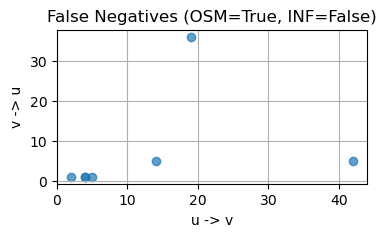

In [85]:
plot_counts(false_negatives, 'False Negatives (OSM=True, INF=False)')

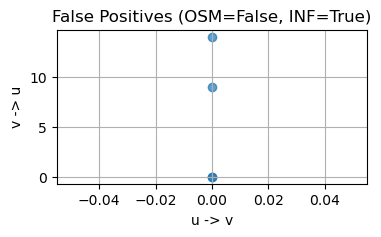

In [86]:
plot_counts(false_positives, 'False Positives (OSM=False, INF=True)')

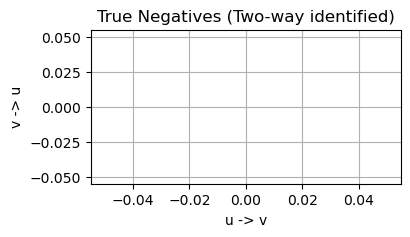

In [87]:
plot_counts(true_negatives, 'True Negatives (Two-way identified)')

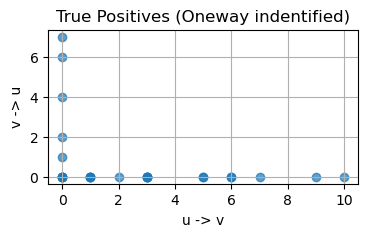

In [88]:
plot_counts(true_positives, 'True Positives (Oneway indentified)')

### Inferred Speed Limit

In [10]:
inf_speed_counts = df['inf_speed_limit'].value_counts()
osm_speed_counts = df['osm_maxspeed'].value_counts()
print(f"inferred speed limits: {inf_speed_counts}\nosm speed limits: {osm_speed_counts}")

inferred speed limits: inf_speed_limit
60    10
30     7
80     6
70     6
20     3
40     3
50     3
Name: count, dtype: int64
osm speed limits: osm_maxspeed
80.0    29
Name: count, dtype: int64
